This notebook leverages the insights from the prior notebook (`DifferentiableTranslationStep01`). The goal is to extend it to work with multiple segments from the user interface and finally, package them in a gradient descent pipeline. 

However, not the final metric will be used, but a dummy one (i.e. minimization of sum of all pixel values).

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch.nn.functional as F
import torchvision.transforms as T

from PIL import Image
import json
from math import prod

transform_t_to_pil = T.ToPILImage()

In [2]:
# Utility functions to read dataset

def get_all_bounding_boxes(item):
    all_boxes = []
    if "bounds" in item.keys():
        all_boxes.append(item["bounds"])
    if "children" in item.keys():
        for child in item["children"]:
            for box in get_all_bounding_boxes(child):
                all_boxes.append(box)
    return all_boxes
"""
returns a list of the segments and a list of coordinates
"""
def segment(image: np.ndarray, rico_json: dict)->[list,list]:
    boxes = get_all_bounding_boxes(rico_json["activity"]["root"])
    segments = []
    coordinates = []
    for box in boxes:
        anchor_point = (box[0],box[1])
        width = box[2]-box[0]
        height = box[3]-box[1]
        cropped_image = im.crop((box[0],box[1],box[2],box[3]))
        # Only include segments that are less than 90% the size of the original image
        if (width*height) < 0.9*(im.size[0]*im.size[1]):
            segments.append(cropped_image)
            coordinates.append((box[0],box[1]))
    return [segments,coordinates]

First, we read the same first UI again:

In [4]:
im = Image.open('combined/5373.jpg')
im = im.resize((1440, 2560), Image.Resampling.LANCZOS)
with open("combined/5373.json", "r") as f:
    image_json = json.load(f)

In [14]:
prod(im.size)

3686400

Lets take a look at all the segments. We will filter out all segments which occupy more than `80%`, because some segments seem to be basically the whole UI.

In [27]:
len(segment(im,image_json)[0])

15

In [28]:
prod(segment(im,image_json)[0][1].size)

1308960

In sum, we have 15 total segments

In [29]:
# Exclude segments which are too big or too small
reduced_segments = [s for s in segment(im,image_json)[0] if (prod(s.size) < 0.80*prod(im.size)) and (prod(s.size)>1)]
len(reduced_segments)

13

So we have 13 total segments which are bigger than `1x1` pixel and smaller than `80%` of the whole image.

Lets take a look at all of the segments:

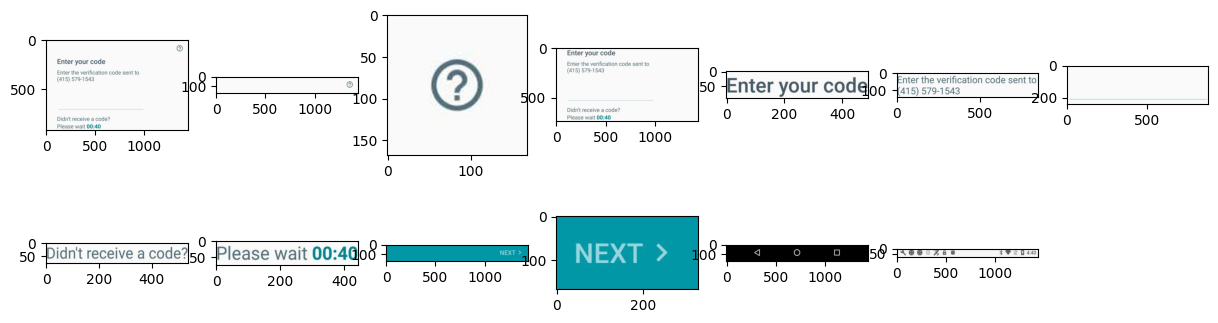

In [30]:
fig = plt.figure(figsize=(15, 4)) 
for n in range(13):
    fig.add_subplot(2, 7, n+1) 
    plt.imshow(reduced_segments[n])

Before we can actually create our model, we need to create a function which retrieves the initial $\theta$ from the data from the rico dataset.
To get this data, we do the following:

- First, we have to calculate the "dewarping" factors, which counteract us projecting the segment onto a bigger canvas
  - We do this by dividing the original canvas size by the segment size. This will be our `x_ratio` and `y_ratio` of the canvas
- Then, we have to translate the original coordinates of the segments in the ui into our theta.
  - The coordinates in the rico dataset are a tuple in the form $(x,y)$
  - In our theta, the two coordinates are ratios in the interval $[-1,1]$, with $(0,0)$ being the center of the image
  - Now, because we already warped our segment, the leftern most coordinate is actually _not_ $-1$, but $-(x_ratio-1)$
    - I am unsure where the extra $-1$ comes from, but this is what i found in the previous notebook
  - To finally do the translation we:
    1. transform the x and y coordinate into the interval $[0,1]$ by dividing them by total height and width of the canvas, respectively
    2. We then transform these values into the interval `[-(x_ratio-1),(x_ratio-1)]` and `[-(y_ratio-1),(y_ratio-1)]` via the basic ` U ~ [0, 1] to U ~ [a, b] with u -> (a - b)*u + b` idea

In [114]:
def calculate_initial_theta(segment, canvas_size, original_position):
    # Theta consists of 6 values, 4 of which we have to calculate.
    x_ratio = canvas_size[0] / segment.size[0]
    y_ratio = canvas_size[1] / segment.size[1]
    # grid_location_x and grid_location_y are basically percentages of height and width and not actual coordinates
    # Because we already warp the segment onto a bigger canvas, this transformation is a bit complicated
    # grid_location_x has to be in the interval [-(x_ratio-1),(x_ratio-1)], i.e. 0 means -(x_ratio - 1) and 1440 means (x_ratio - 1)
    # We can map U ~ [0, 1] to U ~ [a, b] with u -> (a - b)*u + b
    # We first map U ~ [0, max_width] to U ~ [0,1] by dividing by max_width
    original_x_position = original_position[0] / canvas_size[0]
    mapped_x_position = (-(x_ratio - 1) - (x_ratio - 1))*original_x_position + (x_ratio-1)

    original_y_position = original_position[1] / canvas_size[1]
    mapped_y_position = (-(y_ratio - 1) - (y_ratio - 1))*original_y_position + (y_ratio-1)

    return np.array([
        [x_ratio, 0.0    , mapped_x_position],
        [0.0    , y_ratio, mapped_y_position]
    ])

We can now apply this function to the first segment in the UI and check if it matches the position in the original UI:

In [116]:
theta = calculate_initial_theta(segment(im,image_json)[0][1],im.size,segment(im,image_json)[1][1])

(-0.5, 1439.5, 2559.5, -0.5)

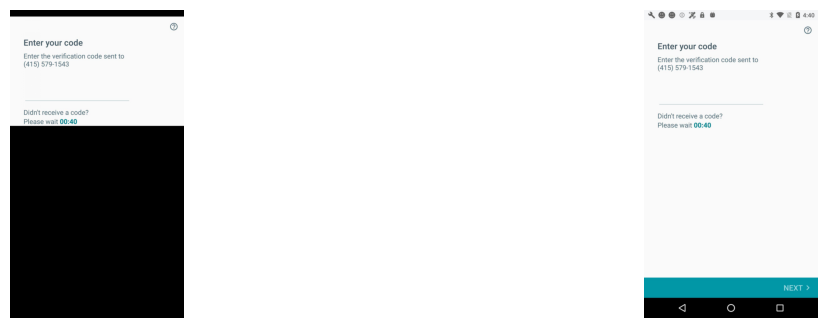

In [121]:
# Do the affine transformation for first segment
theta_tensor = torch.as_tensor(theta)[None]
canvas_size = (1,3,im.size[1],im.size[0])
grid = F.affine_grid(theta_tensor, canvas_size).type(torch.FloatTensor)
x = F.grid_sample(transform(segment(im,image_json)[0][1]).unsqueeze(0), grid)

# Display first transformed segment and original UI
fig = plt.figure(figsize=(15, 4)) 
fig.add_subplot(1, 2, 1) 
plt.imshow(x[0].permute(1, 2, 0).detach())
plt.axis('off') 
fig.add_subplot(1, 2, 2)
plt.imshow(im)
plt.axis('off')

We can see that this function work as we intended.

Now, we can try to create a `nn.Model` which has one trainable vector which controls the coordinates of all of the segments. In the forward pass, the model moves the segments individually on a blank canvas to the desired location and then overlays all of the canvasses, at least thats the idea.

We'll try to make this model as generic as possible, to ensure we can pass other segments to it too.

In [80]:
transform = transforms.Compose([transforms.ToTensor()])


class MultiSegmentUIOptimizer(torch.nn.Module):
    def __init__(self,segments: list, original_image_size: tuple):
        super().__init__()
        init_vector = -5 * torch.rand(len(segments),2) + 2.5 # https://stackoverflow.com/questions/65617507/how-to-create-a-tensor-of-given-shape-and-interval 
        self.coordinates = torch.nn.Parameter(init_vector) # 2 floats per segment, for grid_location_x and grid_location_y
        self.original_image_size = original_image_size
        self.segments = segments
        self.canvas_size = (1,3,original_image_size[1],original_image_size[0])
        print(f"Canvas size is {self.canvas_size}")

    def forward(self):
        segments_on_canvas = []
        for n in range(len(self.segments)):
            # We need to calculate the proper ratios, to artificially warp the segment on to a bigger canvas without distorting it (see notebook 01)
            x_ratio = self.original_image_size[0] / self.segments[n].size[0]
            y_ratio = self.original_image_size[1] / self.segments[n].size[1]
            # Affine matrix
            ########### WILL BREAK GRADIENT! ###########
            theta = [
                [x_ratio, 0.0    , self.coordinates[n][0]],
                [0.0    , y_ratio, self.coordinates[n][1]]
            ]
            theta_tensor = torch.as_tensor(theta)[None]
            ############################################
            
            # Generate flow field
            grid = F.affine_grid(theta_tensor, self.canvas_size).type(torch.FloatTensor)
            x = F.grid_sample(transform(self.segments[n]).unsqueeze(0), grid)
            segments_on_canvas.append(x)
        return segments_on_canvas

In [81]:
msUIo = MultiSegmentUIOptimizer(reduced_segments, im.size)

Canvas size is (1, 3, 2560, 1440)


In [82]:
canvasses = msUIo()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


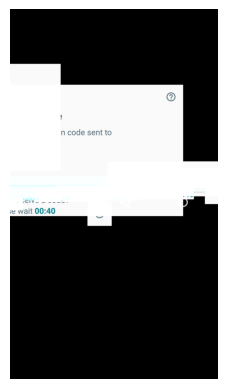

In [83]:
canvas_sum = torch.stack(canvasses).sum(dim=0)[0].permute(1, 2, 0).detach()
plt.imshow(canvas_sum)
plt.axis('off') 
plt.show()